In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from shapely.ops import transform
import matplotlib.patches as patches
from shapely.geometry import Polygon, box, mapping
from shapely.ops import unary_union
from pyproj import Transformer, CRS
import numpy as np
from typing import List, Tuple

from shapely.affinity import rotate

import plotly.graph_objects as go

import ipywidgets as widgets
from IPython.display import display, HTML

from matplotlib.patches import Polygon as MplPolygon

In [2]:
def extract_polygons_from_kml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    # KML namespace
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}

    polygons = []

    # Find ALL <coordinates> inside ANY <Polygon>
    for coords in root.findall(".//kml:Polygon//kml:coordinates", ns):
        text = coords.text.strip()
        pts = []

        for line in text.split():
            lon, lat, *_ = line.split(',')
            pts.append((float(lon), float(lat)))

        polygons.append(pts)

    return polygons


In [3]:
polygons = extract_polygons_from_kml("valid.kml")
print("Found polygons:", len(polygons))

"""for p in polygons:
    print(p[:3], "...")"""


Found polygons: 10


'for p in polygons:\n    print(p[:3], "...")'

In [4]:
def generate_offsets(rect_w = 1, rect_h = 1, w_res = 100, h_res = 100, res_mode = "land"):
    if res_mode == "rect":
        step_w = rect_w / w_res
        step_h = rect_h / h_res
    elif res_mode == "land":
        step_w = 1 / w_res
        step_h = 1 / h_res
    else:
        raise ValueError("Mode not selected")

    offsets = []
    for j in range(h_res):
        for i in range(w_res):
            offsets.append((
                round(i * step_w, 6),
                round(j * step_h, 6)
            ))
    return offsets

In [5]:
def pack_rectangles_in_polygon_rot(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=60,
    scan_mode="new",
    pad_m=0.0,
):
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y
    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_coords_local = [to_local(lon, lat) for lon, lat in polygon_lonlat]
    poly_local = Polygon(poly_coords_local)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []

    rot_origin = poly_local.centroid
    poly_rot = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot = poly_rot.buffer(-pad_m)
        if poly_rot.is_empty:
            return []

    minx, miny, maxx, maxy = poly_rot.bounds

    if try_offsets == True:
        offsets = generate_offsets(
            rect_w=rect_w_m, rect_h=rect_h_m, w_res=w_res, h_res=h_res, res_mode=res_mode
        )
    elif try_offsets == "half":
        offsets = [
            (0.0, 0.0),
            (rect_w_m / 2.0, 0.0),
            (0.0, rect_h_m / 2.0),
            (rect_w_m / 2.0, rect_h_m / 2.0),
        ]
    else:
        offsets = [(0.0, 0.0)]

    best_rects = []
    best_count = -1

    if scan_mode == "old":
        for ox, oy in offsets:
            start_x = minx - (rect_w_m + 1)
            start_y = miny - (rect_h_m + 1)
            xs = np.arange(start_x + ox, maxx + rect_w_m, rect_w_m)
            ys = np.arange(start_y + oy, maxy + rect_h_m, rect_h_m)

            rects = []
            for x in xs:
                for y in ys:
                    candidate = box(x, y, x + rect_w_m, y + rect_h_m)
                    if poly_rot.contains(candidate):
                        rects.append(candidate)

            if len(rects) > best_count:
                best_count = len(rects)
                best_rects = rects

    else:
        for ox, oy in offsets:
            start_x = minx - rect_w_m
            start_y = miny - rect_h_m
            xs = np.arange(start_x + ox, maxx + rect_w_m, rect_w_m)
            ys = np.arange(start_y + oy, maxy + rect_h_m, rect_h_m)

            rects = []
            for x in xs:
                for y in ys:
                    candidate = box(x, y, x + rect_w_m, y + rect_h_m)
                    if poly_rot.covers(candidate):
                        rects.append(candidate)

            if len(rects) > best_count:
                best_count = len(rects)
                best_rects = rects

    result = []
    centers = []
    for r in best_rects:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        coords = list(r_back.exterior.coords)[:-1]
        coords_lonlat = [to_wgs84(x, y) for x, y in coords]
        result.append(coords_lonlat)

        c = r_back.centroid
        centers.append(to_wgs84(c.x, c.y))

    return result, best_count, best_rects, poly_rot, centers

In [6]:
def plot_matplotlib_rectangles(
    polygon_lonlat,
    rects_lonlat,
    centers,
    rect_w_m,
    rect_h_m,
    max_count,
    bearing=0,
    pad_ratio=0.05,
    pad_m=0.0
):
    # -----------------------------
    # Convert polygon to local CRS
    # -----------------------------
    xs = [p[0] for p in polygon_lonlat]
    ys = [p[1] for p in polygon_lonlat]

    centroid_lon = sum(xs) / len(xs)
    centroid_lat = sum(ys) / len(ys)

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={centroid_lat} +lon_0={centroid_lon} +units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    # Local polygon
    poly_local = Polygon([to_local(lon, lat) for lon, lat in polygon_lonlat])

    # -----------------------------
    # Padding polygon (same as pack)
    # -----------------------------
    if pad_m > 0:
        poly_padded_local = poly_local.buffer(-pad_m)
        if poly_padded_local.is_empty:
            poly_padded_lonlat = []
        else:
            poly_padded_lonlat = [to_wgs84(x, y) for x, y in poly_padded_local.exterior.coords]
    else:
        poly_padded_lonlat = []

    # -----------------------------
    # Normal bounding-box padding for axes
    # -----------------------------
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    width = max_x - min_x
    height = max_y - min_y
    width = max(width, 1e-9)
    height = max(height, 1e-9)
    aspect = width / height

    pad_x = width * pad_ratio
    pad_y = height * pad_ratio

    # Axis limits
    min_x_p = min_x - pad_x
    max_x_p = max_x + pad_x
    min_y_p = min_y - pad_y
    max_y_p = max_y + pad_y

    # -----------------------------
    # Plot
    # -----------------------------
    base_h = 8
    fig_w = base_h * aspect
    fig_h = base_h

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    # Original polygon
    ax.add_patch(MplPolygon(
        polygon_lonlat,
        closed=True,
        facecolor=(0.6, 0.6, 0.6, 0.7),
        edgecolor="black",
        linewidth=2
    ))

    # Padded outline (inner polygon)
    if len(poly_padded_lonlat) > 0:
        ax.add_patch(MplPolygon(
            poly_padded_lonlat,
            closed=True,
            fill=False,
            edgecolor="red",
            linewidth=2,
            linestyle="--"
        ))

    # Rectangles
    for i, rect in enumerate(rects_lonlat):
        ax.add_patch(MplPolygon(rect, closed=True, fill=False, edgecolor="blue", linewidth=1))

        cx, cy = centers[i]
        font_size = max(10, min(rect_w_m, rect_h_m) * 0.6)
        ax.text(cx, cy, str(i+1), ha="center", va="center", fontsize=font_size)

    ax.set_title(f"Max count: {max_count}", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal", adjustable="datalim")

    ax.set_xlim(min_x_p, max_x_p)
    ax.set_ylim(min_y_p, max_y_p)

    plt.tight_layout()
    plt.show()


In [7]:
current_polygon = polygons[0]
width = 20
height = 10
x_res = 100
y_res = 100
angle = 0
boundary_padding = 3

In [8]:
a, b, c, poly_local, centers = pack_rectangles_in_polygon_rot(
    polygon_lonlat=current_polygon,
    rect_w_m=width,
    rect_h_m=height,
    try_offsets=True,
    w_res=x_res,
    h_res=y_res,
    res_mode="land",
    angle_deg=angle,
    pad_m=boundary_padding
)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


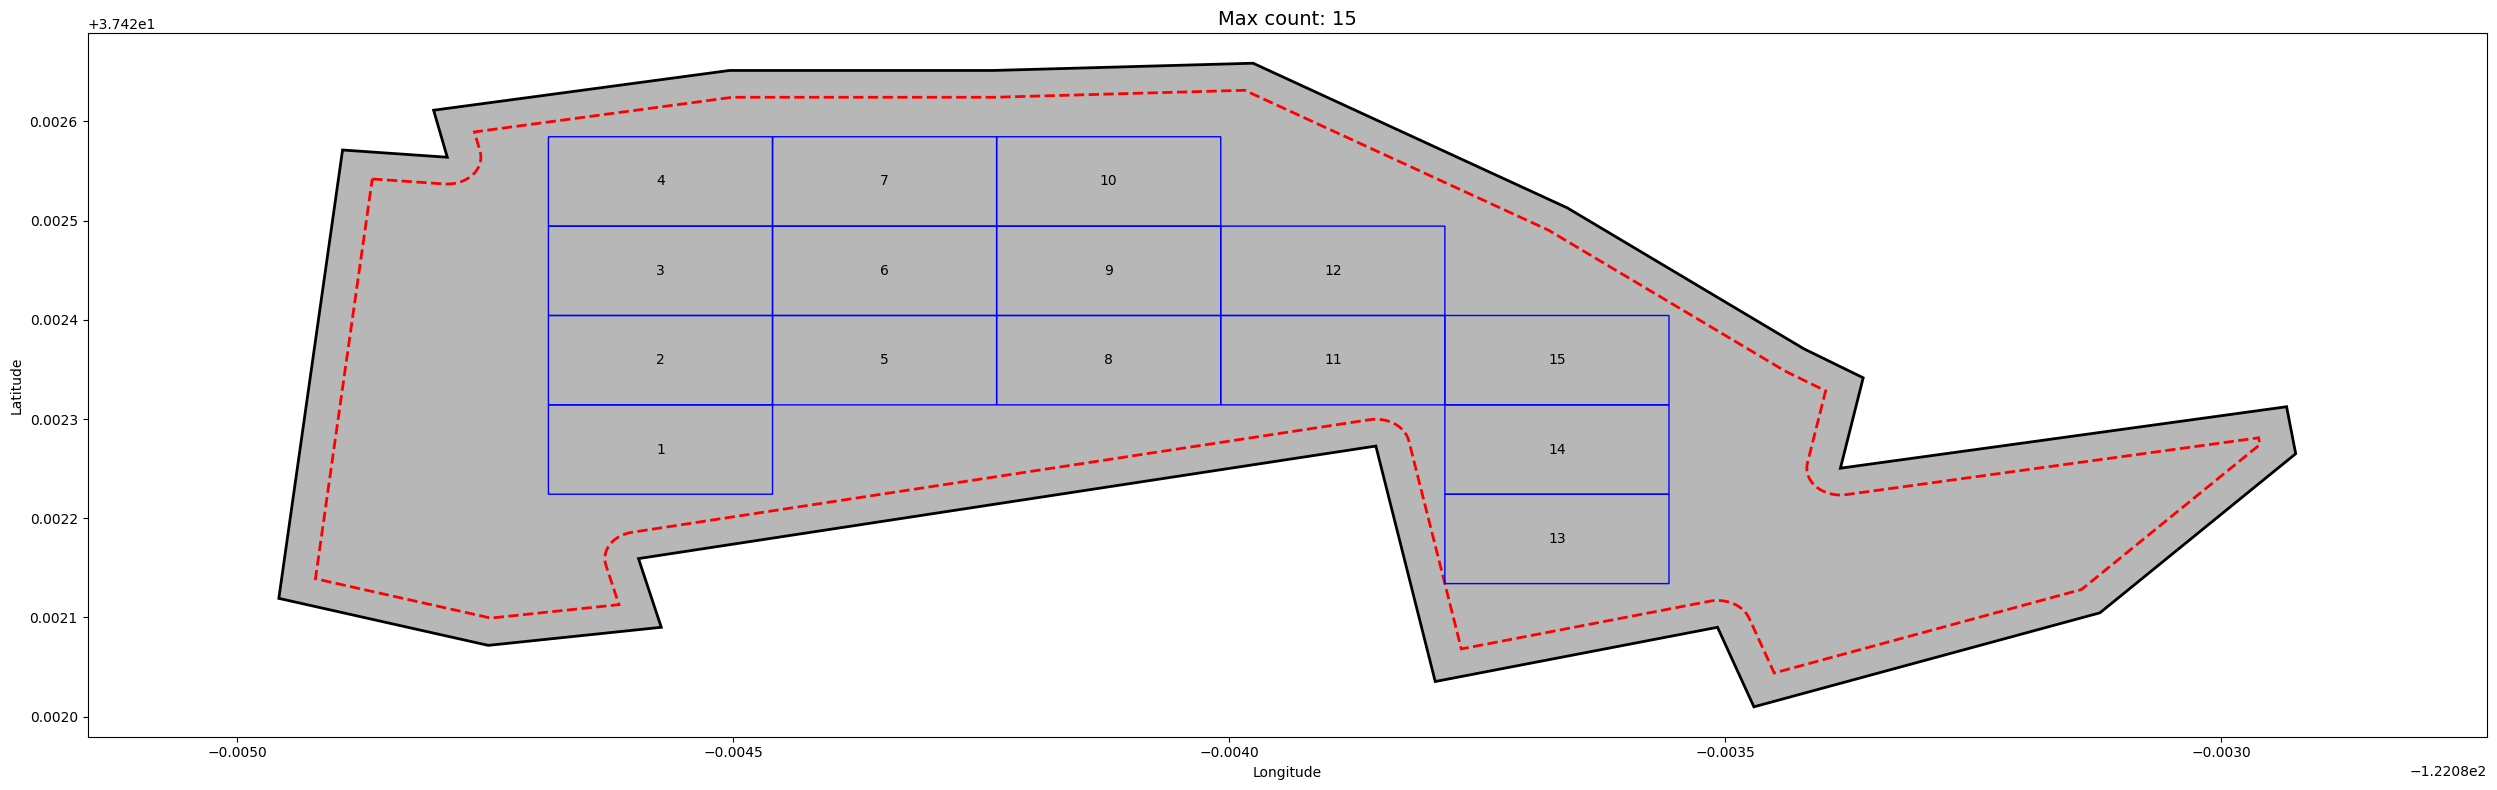

In [9]:
plot_matplotlib_rectangles(
    polygon_lonlat=current_polygon,
    rects_lonlat=a,
    centers=centers,
    rect_w_m=width,
    rect_h_m=height,
    max_count=b,
    bearing=0,
    pad_m=boundary_padding)